
# A/B‑тест: Social Proof на екрані підписки 

**Автор:** Oleh Ustimov / Junior Data Analyst  
**Опис:** Ноутбук з повним аналізом A/B‑тесту: завантаження даних, підсумкова таблиця, Z‑тест для пропорцій, візуалізації з 95% ДІ та динаміка конверсії за днями.


In [1]:


import pandas as pd
import numpy as np
from datetime import datetime
import math

import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline


## 1) Завантаження даних

In [2]:
# Підключення Google Sheets як CSV
sheet_id = "1xWtyhQ4O7qKezc4PkN4kTCyajavfXDBZVTo3nIPOVF4"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

df = pd.read_csv(csv_url)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'] = df['timestamp'].dt.date

df.head()

,user_id,timestamp,test_group,conversion,date
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:56,a,0,2023-07-04
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45,b,0,2023-07-06
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:34,b,0,2023-07-10
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:50,b,0,2023-07-20
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50,b,0,2023-07-19


## 2) Підсумок по групах (користувачі, конверсії, CR, дати/тривалість)

In [3]:

summary = (
    df.groupby('test_group')
      .agg(users=('user_id', 'nunique'),
           conversions=('conversion', 'sum'))
      .reset_index()
      .sort_values('test_group')
)
summary['cr'] = summary['conversions'] / summary['users']


start_date = df['date'].min()
end_date = df['date'].max()
duration_days = (end_date - start_date).days + 1


display(summary.assign(cr_pct=(summary['cr']*100).round(2)).rename(columns={'cr_pct':'conversion_rate_%'}))
print(f"Початок тесту: {start_date} | Кінець тесту: {end_date} | Тривалість (днів): {duration_days}")


,test_group,users,conversions,cr,conversion_rate_%
0,a,10013,611,0.061021,6.1
1,b,9985,889,0.089034,8.9


Початок тесту: 2023-07-03 | Кінець тесту: 2023-07-25 | Тривалість (днів): 23


## 3) Статистична перевірка: двосторонній Z‑тест для пропорцій (H0: pA = pB)

In [4]:

# Підготовка даних для тесту
counts = summary['conversions'].values
nobs = summary['users'].values

z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.3f}")
print(f"p-value: {p_val:.6f}")
if p_val < 0.05:
    print("Висновок: різниця значуща → відхиляємо H0")
else:
    print("Висновок: різниця незначуща → не відхиляємо H0")


Z-статистика: -7.520
p-value: 0.000000
Висновок: різниця значуща → відхиляємо H0


## 4) 95% довірчі інтервали для конверсії (Wald)

In [5]:

z = 1.959963984540054  # 95% двосторонній
summary['se'] = np.sqrt(summary['cr'] * (1 - summary['cr']) / summary['users'])
summary['ci_low'] = (summary['cr'] - z * summary['se']).clip(lower=0)
summary['ci_high'] = (summary['cr'] + z * summary['se']).clip(upper=1)

summary_ci = summary[['test_group','users','conversions','cr','ci_low','ci_high']].copy()
summary_ci['cr_%'] = (summary_ci['cr']*100).round(2)
summary_ci['ci_low_%'] = (summary_ci['ci_low']*100).round(2)
summary_ci['ci_high_%'] = (summary_ci['ci_high']*100).round(2)
display(summary_ci[['test_group','users','conversions','cr_%','ci_low_%','ci_high_%']])


,test_group,users,conversions,cr_%,ci_low_%,ci_high_%
0,a,10013,611,6.1,5.63,6.57
1,b,9985,889,8.9,8.34,9.46


## 5) Візуалізація: порівняння конверсій (95% ДІ)

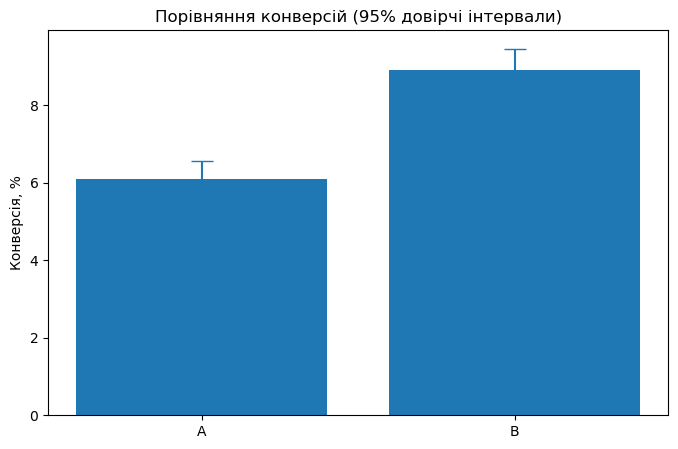

In [6]:

groups = ['A' if g=='a' else 'B' for g in summary['test_group']]
crs = (summary['cr']*100).tolist()
yerr = ((summary['ci_high']-summary['cr'])*100).tolist()

plt.figure(figsize=(8,5))
x = np.arange(len(groups))
plt.bar(x, crs)
plt.errorbar(x, crs, yerr=yerr, fmt='none', capsize=8)
plt.xticks(x, groups)
plt.ylabel("Конверсія, %")
plt.title("Порівняння конверсій (95% довірчі інтервали)")
plt.show()


## 6) Бонус: динаміка конверсії за днями (A vs B)

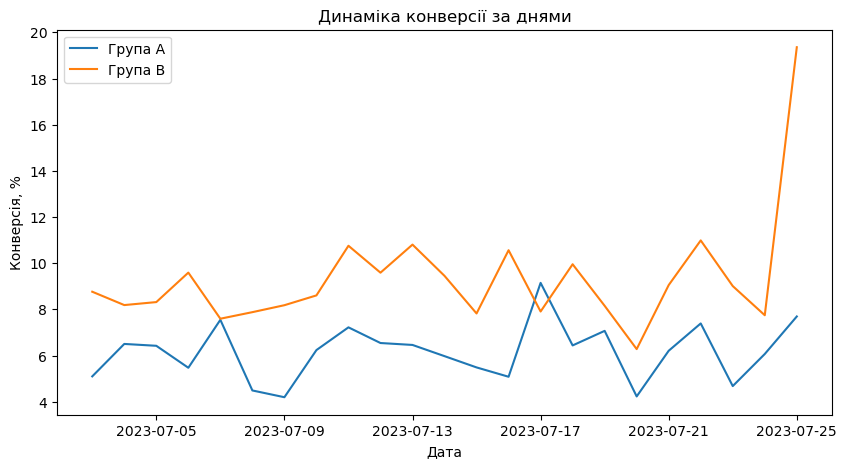

In [7]:

daily = (
    df.groupby(['date','test_group'])
      .agg(cr=('conversion','mean'),
           n=('user_id','nunique'))
      .reset_index()
)

plt.figure(figsize=(10,5))
for grp, label in [('a','A'), ('b','B')]:
    part = daily[daily['test_group']==grp].sort_values('date')
    plt.plot(part['date'], part['cr']*100, label=f"Група {label}")
plt.xlabel("Дата")
plt.ylabel("Конверсія, %")
plt.title("Динаміка конверсії за днями")
plt.legend()
plt.show()



## 7) Висновки та наступні кроки
- Якщо результат значущий та ліфт позитивний — **рекомендується впровадити варіант B (Social Proof)** з подальшим моніторингом 1–2 тижні (CR, Refund/chargeback).
- Якщо різниця незначуща — **продовжити тест** для меншого MDE або зупинити та перейти до наступної гіпотези.
- Якщо результат гірший — **повернути контроль** і протестувати альтернативи (value‑based копірайт, інший формат social proof тощо).
